In [18]:
#SUNSET


def getPlaylists(access_token):
    user_id = os.environ.get('user_id')
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    response = requests.get(f"{BASE_URL}users/{user_id}/playlists", headers=headers)
    if response.ok:
        return response.json()
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
    return None

def dfPlaylists(user_playlists_json):
    df_playlists = pd.json_normalize(user_playlists_json['items'], sep = '_', record_prefix = 'playlist_', errors = 'ignore')
    return df_playlists

def getColumns(df_playlists, relevant_columns):
    cleaned_columns = [col for col in relevant_columns if col in df_playlists.columns]
    return df_playlists[cleaned_columns]


def getRelatedArtists(access_token, artist_id):
    user_id = os.environ.get('user_id')
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    
    response = requests.get(f"{BASE_URL}artists/{artist_id}/related-artists", headers=headers)
    if response.ok:
        return response.json()
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
    return None


def relatedDf(related_json):
    related = []
    if 'artists' in related_json:
        for artist in related_json['artists']:
            artist_dict = {
                'Name': artist['name'],
                'Genres': ', '.join(artist['genres']) if artist['genres'] else 'N/A',  
                'Followers': artist['followers']['total'],
                'Popularity': artist['popularity'],
            }
            related.append(artist_dict)
    df_related = pd.DataFrame(related)
    return df_related

# Authorization & Set-up

In [19]:
import os
current_directory = os.getcwd()
%run packages.py #Download all required packages in one fell swoop. 

In [20]:
AUTH_URL = 'https://accounts.spotify.com/api/token'
BASE_URL = 'https://api.spotify.com/v1/'

In [21]:
def getAuth():
    # Retrieve client ID & secret from env file & encode.
    dotenv_path = '/Users/mariam/Documents/GitHub/advanced_python/credentials.env' # Put your credentials in.
    load_dotenv(dotenv_path=dotenv_path)  # Use the path for dotenv
    client_id, client_secret = os.environ.get('client_id'), os.environ.get('client_secret') #verify var names.
    credentials = f"{client_id}:{client_secret}"
    credentials_b64 = base64.b64encode(credentials.encode())
    
    url = 'https://accounts.spotify.com/api/token'
    token_data = {'grant_type': 'client_credentials'}
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Authorization': f'Basic {credentials_b64.decode()}'
    }
    
    response = requests.post(url, data=token_data, headers=headers)
    if response.ok:
        return response.json().get('access_token')
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
        return None

In [23]:
#Pull all user playlists for processing, specifically returning a dict of playlist ids & titles. 
def getPlaylistsid(access_token):
    user_id = os.environ.get("user_id")
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    response = requests.get(f"{BASE_URL}users/{user_id}/playlists", headers=headers)

    if response.ok:
        playlists_json = response.json()
        playlist_info = [
            {"id": playlist["id"], "name": playlist["name"]}
            for playlist in playlists_json.get("items", [])
        ]
        return playlist_info
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
        return None

def getPlaylist(playlist_id, access_token):
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    
    all_tracks = []
    response = requests.get(f"{BASE_URL}playlists/{playlist_id}/tracks?limit=100", headers=headers)
    if response.ok:
        data = response.json()
        all_tracks.extend(data['items'])  
        
        while data['next']:
            response = requests.get(data['next'], headers=headers) #Use the 'next' URL provided by the API? Or manual?
            if response.ok:
                data = response.json()
                all_tracks.extend(data['items'])  
            else:
                print(f"Invalid: {response.status_code}, {response.text}")
                break  

        return all_tracks
    else:
        print(f"Invalid: {response.status_code}, {response.text}")
        return None

def dfPlaylist(tracks_json):
    tracks = []
    for item in tracks_json:
        track = item.get('track', {})
        if track:  
            track_info = {
                'id': track.get('id'),
                'title': track.get('name'),
                'popularity': track.get('popularity'),
                'album': track['album'].get('name'),
                'release_date': track['album'].get('release_date'),
                'album_total_tracks': track['album'].get('total_tracks'),
                'artist': ', '.join([artist['name'] for artist in track['artists']]), 
                'artist_id': track['artists'][0]['id'] if track['artists'] else None,  
                'album_id': track['album'].get('id')
            }
            tracks.append(track_info)
    
    df_tracks = pd.DataFrame(tracks)
    return df_tracks

In [32]:
def getAudiosFeatures(track_ids, access_token):
    MAX_TRACKS = 100
    all_features = []  
    
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    for i in range(0, len(track_ids), MAX_TRACKS):
        chunk = track_ids[i:i+MAX_TRACKS]
        track_ids_str = ",".join(chunk)

        response = requests.get(f"{BASE_URL}audio-features?ids={track_ids_str}", headers=headers)
        if response.ok:
            data = response.json()
            all_features.extend(data['audio_features'])
        else:
            print(f"Invalid: {response.status_code}, {response.text}")
            return None  

    return all_features

def genretoPlaylist(df_tracks, df_artists): 
    df_tmp_genre = pd.Series(df_artists.set_index('id')['genres'].to_dict())
    df_tracks['genres'] = df_tracks['artist_id'].map(df_tmp_genre)
    return df_tracks

def audioFeaturesDf(audio_features_json): 
    features_list = audio_features_json['audio_features'] if 'audio_features' in audio_features_json else audio_features_json
    
    features_data = []
    for feature in features_list:
        if feature:  
            features = {
                'danceability': feature['danceability'],
                'energy': feature['energy'],
                'key': feature['key'],
                'loudness': feature['loudness'],
                'mode': feature['mode'],
                'speechiness': feature['speechiness'],
                'acousticness': feature['acousticness'],
                'instrumentalness': feature['instrumentalness'],
                'liveness': feature['liveness'],
                'valence': feature['valence'],
                'tempo': feature['tempo'],
                'duration_ms': feature['duration_ms'],
                'time_signature': feature['time_signature']
            }

            if 'id' in feature:
                features['id'] = feature['id']
            features_data.append(features)
    
    df_features = pd.DataFrame(features_data)
    if 'id' in df_features.columns:
        df_features.set_index('id', inplace=True)
    return df_features

In [34]:
def getArtist(artist_ids, access_token):
    MAX_IDS = 50
    artists_info = {'artists': []}
    
    unique_artist_ids = list(set(artist_ids))
    
    for i in range(0, len(unique_artist_ids), MAX_IDS):
        chunk = unique_artist_ids[i:i+MAX_IDS]
        artist_ids_str = ",".join(chunk)
        
        headers = {"Authorization": f"Bearer {access_token}"}
        response = requests.get(f"{BASE_URL}artists?ids={artist_ids_str}", headers=headers)
        
        if response.ok:
            chunk_data = response.json()
            artists_info['artists'].extend(chunk_data['artists'])
        else:
            print(f"Invalid: {response.status_code}, {response.text}")
    
    return artists_info

def artistDf(artist_json):
    artists = []
    for artist in artist_json['artists']:
        artist_info = {
            'followers': artist['followers']['total'],
            'genres': artist['genres'],  
            'id': artist['id'],
            'name': artist['name'],
            'popularity': artist['popularity']
        }
        artists.append(artist_info)
    df_artists = pd.DataFrame(artists)
    return df_artists

# Charts

In [43]:
def plotTopGenres(df_artists):
    all_genres = [genre for sublist in df_artists['genres'] if isinstance(sublist, list) for genre in sublist]
    genre_counts = pd.Series(all_genres).value_counts().nlargest(10)  #Get the top 10 genres.
    
    data = {
        'genres': genre_counts.index.tolist(),
        'counts': genre_counts.values
    }
    source = ColumnDataSource(data=data)
    
    p = figure(x_range=data['genres'], title="Top 10 Genres Based on Primary Genre of Artists",
               toolbar_location=None, tools="", height=400)
    
    hover = HoverTool()
    hover.tooltips = [
        ("Genre", "@genres"),
        ("Count", "@counts")
    ]
    p.add_tools(hover)
    
    p.vbar(x='genres', top='counts', width=0.9, source=source, fill_color='purple', line_color=None)
    
    p.xaxis.major_label_orientation = 1.2
    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    
    output_notebook()
    show(p)

In [44]:
def wordCloud(df_tracks):
    all_genres = ' '.join([genre for sublist in df_tracks['genres'].dropna() for genre in sublist])
    
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white', 
                          colormap='inferno',  
                          min_font_size = 10).generate(all_genres)
    
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

In [45]:
def plotPopularity(df_artists):
    bin_edges = np.arange(0, 105, 5)
    counts, _ = np.histogram(df_artists['popularity'], bins=bin_edges)
    percentages = (counts / df_artists['popularity'].count()) * 100
    avg_popularity = df_artists['popularity'].mean()

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(range(len(bin_edges)-1), percentages, color='purple', edgecolor='black')
    for bar, count in zip(bars, counts):
        if count !=0:
            ax.annotate(f'{count}', 
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                        xytext=(0, 3),  
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_xticks(range(len(bin_edges)-1))
    ax.set_xticklabels([f'{bin_edges[i]}-{bin_edges[i+1]}' for i in range(len(bin_edges)-1)], rotation=45, ha="right")

    ax.set_xlabel('Popularity Score Range')
    ax.set_ylabel('Percentage of Artists')
    ax.set_title('Overall Playlist Popularity')

    caption = f"How unique is your taste? This playlist's average popularity score is roughly {avg_popularity:.1f}"
    fig.text(0.5, 0.01, caption, ha='center', va='bottom', fontsize=10, color='gray')

    plt.tight_layout()
    plt.show()

In [51]:
def plotgenreDiversity(df_artists):
    all_genres = set()
    for genres in df_artists['genres']:
        all_genres.update(genres)
    total_unique_genres = len(all_genres)
    
    # Prep data for the top 10 artists by genre count.
    df_artists['genre_count'] = df_artists['genres'].apply(len)
    top_artists = df_artists.nlargest(10, 'genre_count')
    
    source = ColumnDataSource(data=dict(
        names=top_artists['name'],
        counts=top_artists['genre_count'],
        genres=['; '.join(genres) for genres in top_artists['genres']]
    ))
    
    p = figure(x_range=top_artists['name'], height=400, title="Top 10 Artists by Genre Diversity",
               toolbar_location=None, tools="")
    p.vbar(x='names', top='counts', width=0.9, source=source, legend_field="names", 
           line_color='white', fill_color='purple')
    
    p.add_tools(HoverTool(tooltips=[("Artist", "@names"), ("# Genres", "@counts"), ("Genres", "@genres")]))
    
    p.xaxis.major_label_orientation = "vertical"
    p.xgrid.grid_line_color = None
    p.y_range.start = 0
    
    caption_text = f'<div><strong>Total Unique Genres in Playlist: {total_unique_genres}</strong></div>'
    caption = Div(text=caption_text)
    layout = column(p, caption)
    
    output_notebook() 
    show(layout)

/var/folders/kj/3n05xf5101nd06t7q93vbtnc0000gn/T/ipykernel_67389/2944227424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tracks['release_year'] = pd.to_datetime(df_tracks['release_date']).dt.year


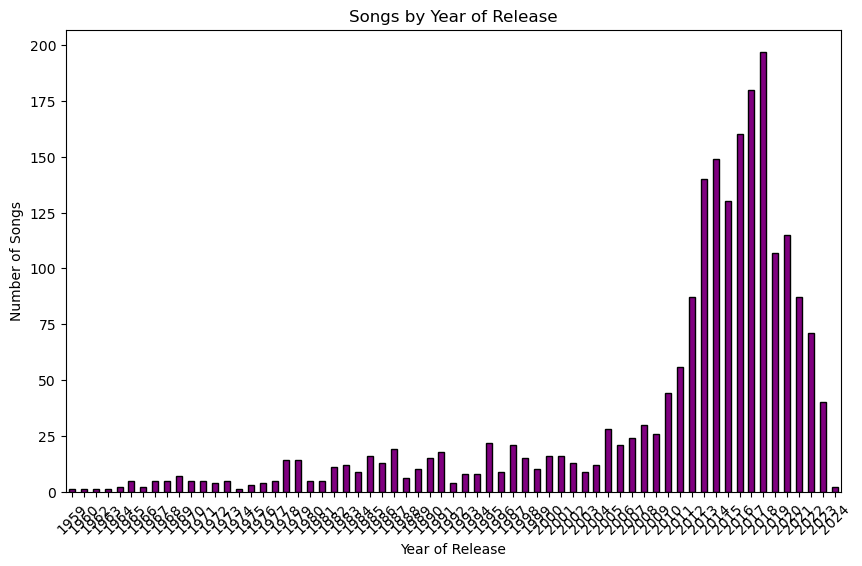

In [52]:
def plotRelease(df_tracks):
    #filter out poorly formatted dates
    df_tracks = df_tracks[df_tracks['release_date'].str.len()==10]
    df_tracks['release_year'] = pd.to_datetime(df_tracks['release_date']).dt.year
    tracks_by_year = df_tracks['release_year'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    tracks_by_year.plot(kind='bar', color='purple', edgecolor='black') 
    plt.xlabel('Year of Release')
    plt.ylabel('Number of Songs')
    plt.title('Songs by Year of Release')
    plt.xticks(rotation=45)
    plt.show()

plotRelease(df_tracks)

In [53]:
def plotTopofPlaylist(df_tracks, artists_df):
    fig, axs = plt.subplots(1, 2, figsize=(20, 6)) 

    top_5_songs = df_tracks.sort_values(ascending=False, by='popularity')[:5]
    axs[0].bar(top_5_songs['title'], top_5_songs['popularity'], color='purple', width=0.5)
    axs[0].set_title('Top 5 Most Popular Songs in Playlist')
    axs[0].set_xlabel('Song Title')
    axs[0].set_ylabel('Popularity')
    axs[0].tick_params(axis='x', rotation=90)

    top_5_artists = artists_df.sort_values(ascending=False, by='popularity')[:5]
    axs[1].bar(top_5_artists['name'], top_5_artists['popularity'], color='purple', width=0.4)
    axs[1].set_title('Top 5 Spotify Artists in Playlist')
    axs[1].set_xlabel('Artist')
    axs[1].set_ylabel('Popularity')
    
    plt.tight_layout()
    plt.show()

In [54]:

def plotAudioFeatures(df_audio_features):
    features = ['danceability', 'energy', 'liveness']
    data = [df_audio_features[feature] for feature in features]
    
    colors = ['skyblue', 'lightgreen', 'salmon']
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    # plt.style.use('seaborn-deep')

    ax1.hist(data, bins=20, label=features)
    ax1.set_xlabel("Scale")
    ax1.set_ylabel("Frequency")
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    
    box = ax2.boxplot(data, vert=False, positions=np.arange(len(data)) + 1, patch_artist=True)
    
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    ax2.yaxis.tick_right()
    ax2.set_yticks(np.arange(1, len(data) + 1))
    ax2.set_yticklabels(features)
    ax2.yaxis.set_label_position("right")
    ax2.set_ylabel("Features")

    plt.title("Audio Features Distributions")
    plt.show()

In [55]:
def plotDuration(df_audio_features):
    plt.hist(df_audio_features.duration_ms, color='purple', rwidth=0.7)
    plt.xlabel("Song Duration")
    plt.xticks(rotation=90)
    plt.ylabel("Frequency")
    plt.title("Song Duration Distribution")
    plt.show()

In [56]:
def plotTempo(df_audio_features):
    plt.figure(figsize=(10, 6))
    plt.hist(df_audio_features['tempo'], bins=30, color='purple', edgecolor='black')
    plt.xlabel('Tempo (BPM)')
    plt.ylabel('Number of Songs')
    plt.title('Frequency of Song Tempos')
    plt.show()

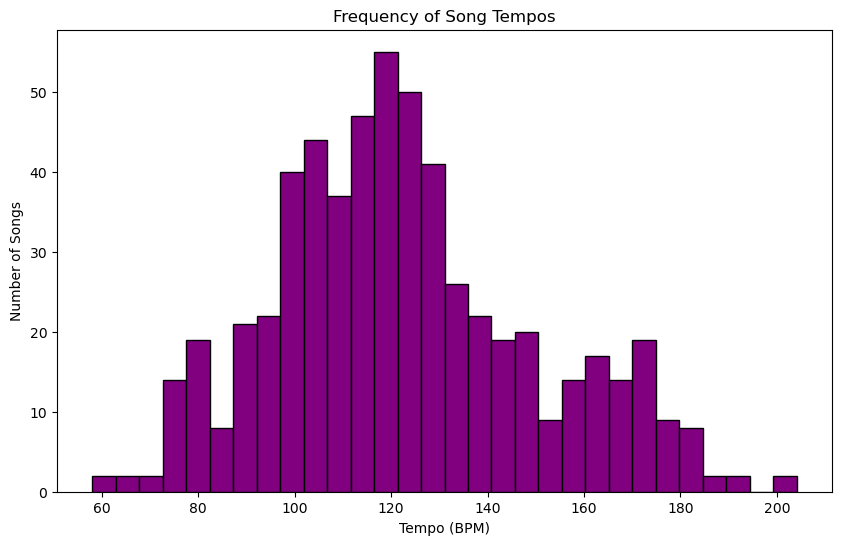

In [ ]:
#look for bottlenecks once we have the finalized code
%prun plotTempo(df_audio_features)

# Testing

Loading BokehJS ...

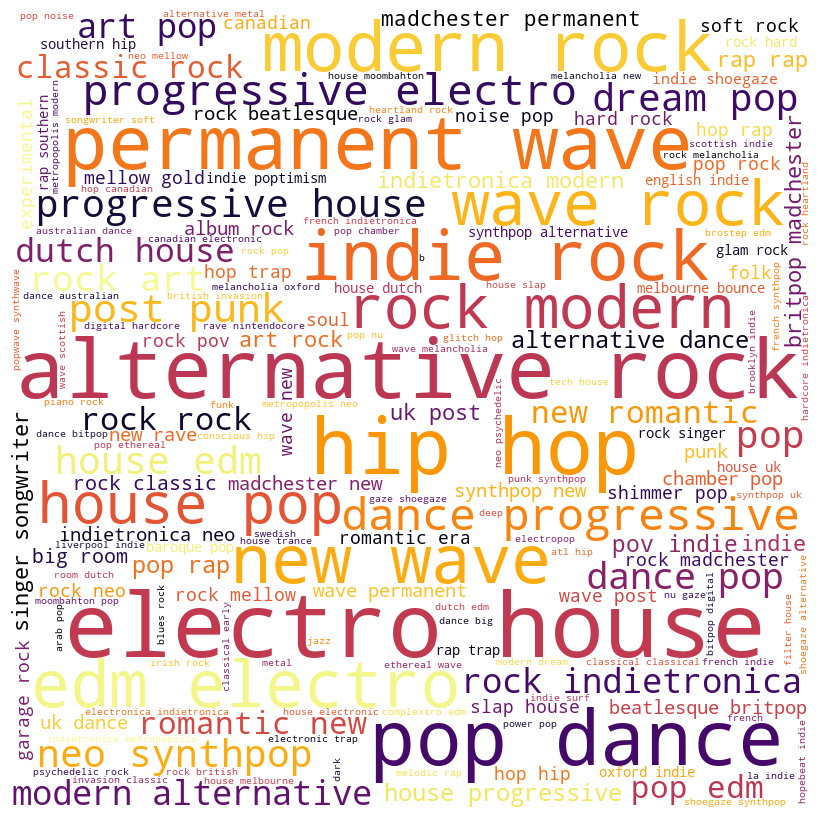

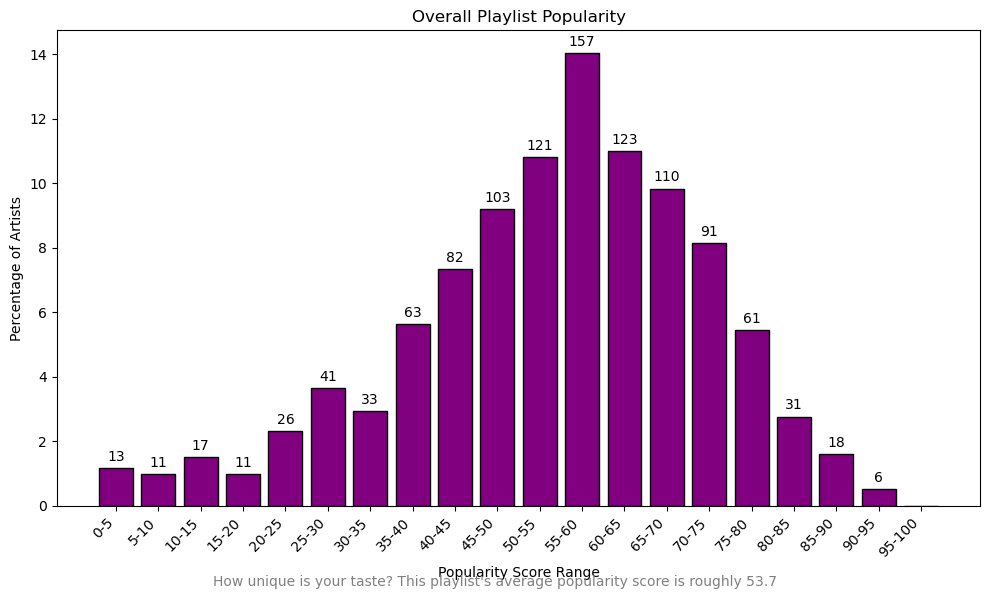

Loading BokehJS ...

/var/folders/kj/3n05xf5101nd06t7q93vbtnc0000gn/T/ipykernel_67389/2944227424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tracks['release_year'] = pd.to_datetime(df_tracks['release_date']).dt.year


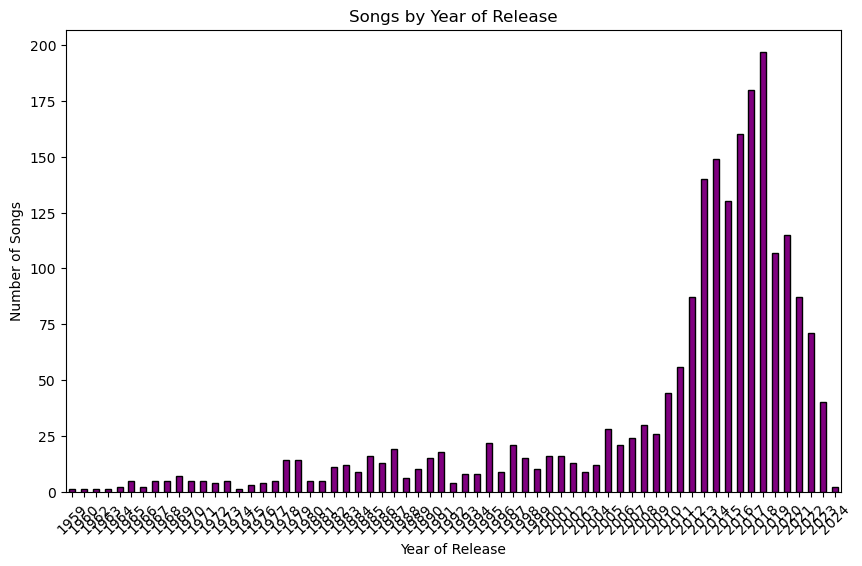

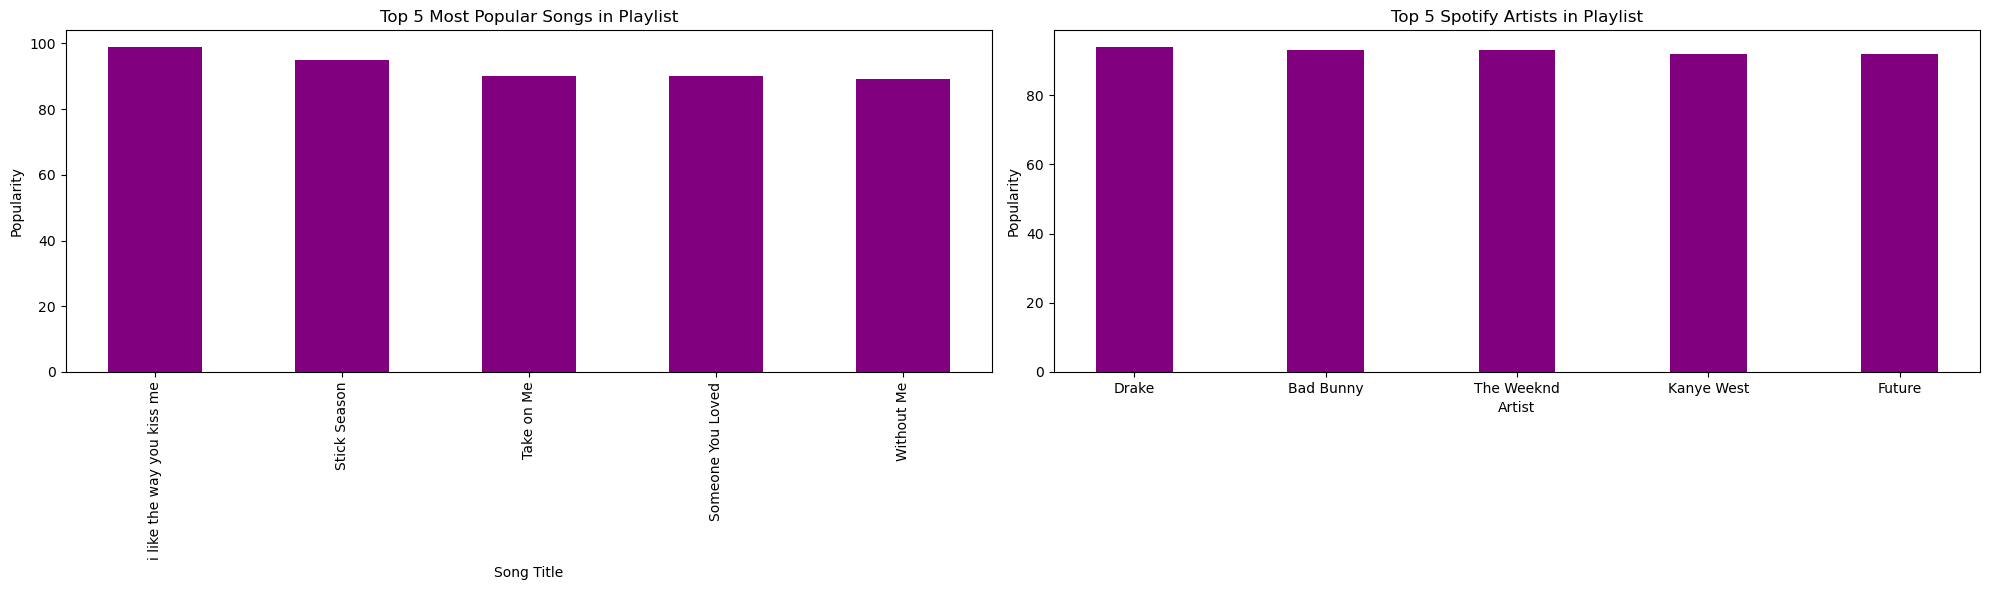

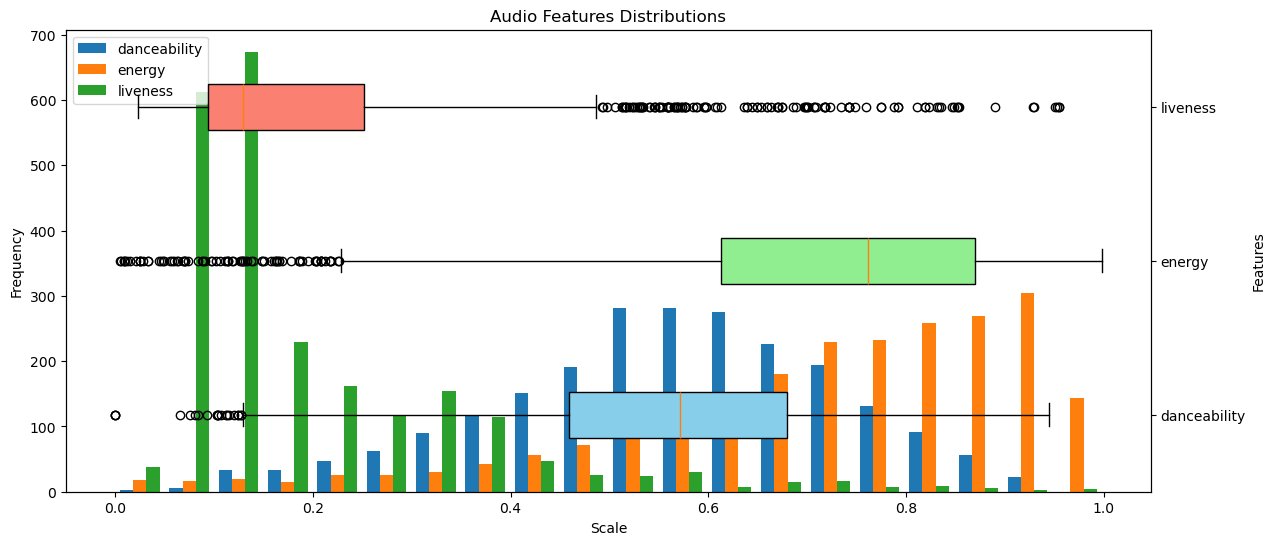

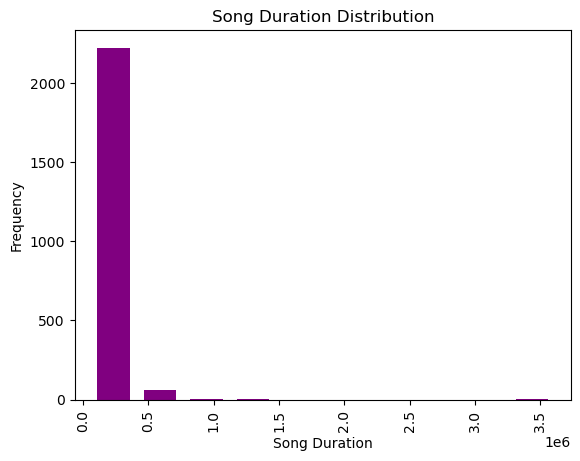

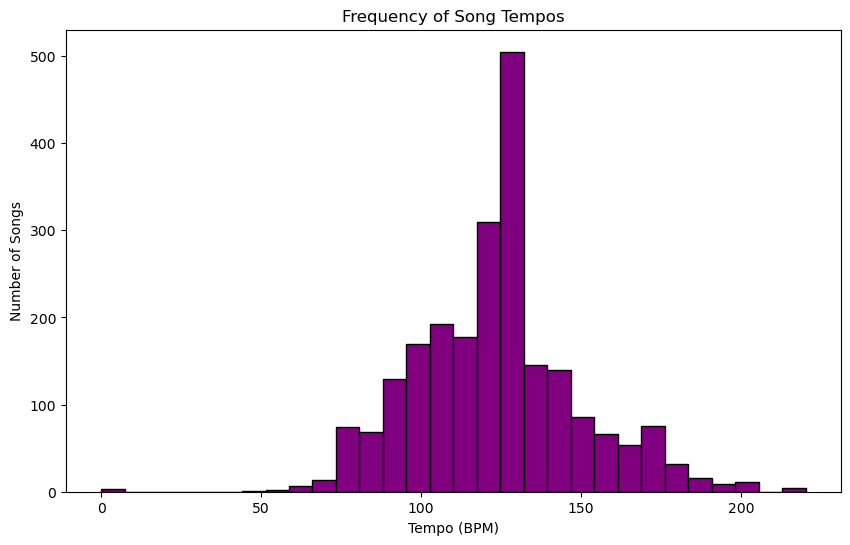

Time elapsed: 9.189820000000001 s


In [58]:
t = time.process_time()

access_token = getAuth()
playlist_info = getPlaylistsid(access_token)

df_tracks = pd.DataFrame()

for playlist in playlists:
    playlist_id = playlist['id']
    playlist_name = playlist['name']

    tracks_json = getPlaylist(playlist_id, access_token)

    if tracks_json:  
        playlist_tracks_df = dfPlaylist(tracks_json)
        playlist_tracks_df['playlist'] = playlist_name
        df_tracks = pd.concat([df_tracks, playlist_tracks_df], ignore_index=True)

df_tracks

artists = getArtist(list(df_tracks.artist_id), access_token) 
df_artists = artistDf(artists)
df_tracks_updated = genretoPlaylist(df_tracks, df_artists)

unique_track_ids = df_tracks["id"].tolist()
audio_features = getAudiosFeatures(list(df_tracks.id), access_token)
df_audio_features = audioFeaturesDf(audio_features)

plotTopGenres(df_artists)
wordCloud(df_tracks_updated)
plotPopularity(df_artists)
plotgenreDiversity(df_artists)
plotRelease(df_tracks_updated)
plotTopofPlaylist(df_tracks_updated, df_artists)
plotAudioFeatures(df_audio_features)
plotDuration(df_audio_features)
plotTempo(df_audio_features)

elapsed_time = time.process_time() - t
print('Time elapsed:', elapsed_time,'s')